This notebook aims to investigate the relationships between ABI and GLM and develop the CTH lightning parameterizations.

## Read Data

In [1]:
import numpy as np
import pandas as pd
import proplot as plot
from glob import glob
import dask.dataframe as dd
import statsmodels.api as sm
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d

from satpy import Scene

In [2]:
merge_dir = '../data/GOES-16/merged/'
df = dd.read_csv(merge_dir+'merged_2020*.csv', skiprows=4).compute().dropna()
df = df[df['w']>0]
# df['flash_extent_density'] /= 5  # per 5 minutes --> per minute
# df = pd.read_csv(merge_dir+'merged_2020*.csv', skiprows=4)
# df = dd.read_csv(merge_dir+'merged_20201[5-6]*.csv', skiprows=4)
# df = pd.read_csv(glob(merge_dir+'*.csv')[0], skiprows=2)

## Check Bin Counts

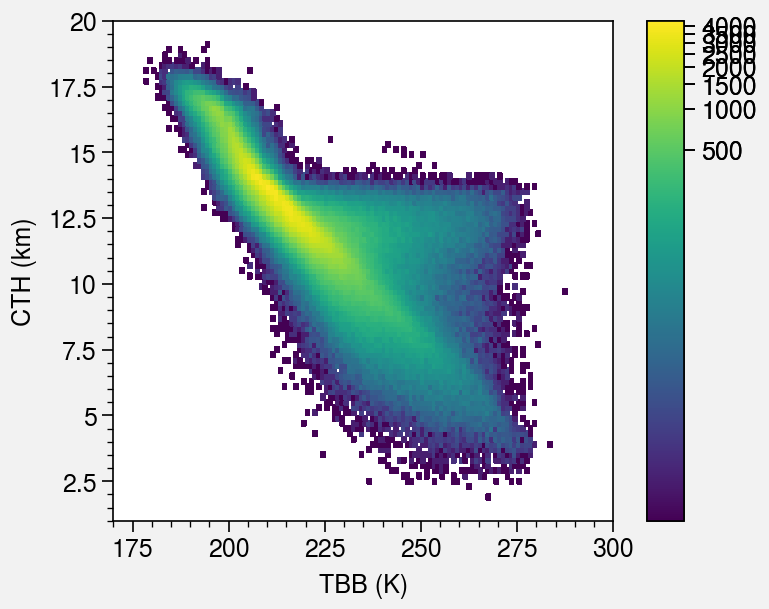

In [4]:
# plot the counts in each bin
fig, axs = plot.subplots()

cth_bins = np.arange(1, 20.2, 0.2)
tbb_bins = np.arange(170, 301, 1)

m = axs.hist2d(df['C13'].reset_index(drop=True),
               df['HT'].reset_index(drop=True),
               bins=(tbb_bins, cth_bins),
#                range=[[170, 300], [1, 20]],
               cmap='viridis',
               norm='log',
              )

axs.colorbar(m[3], loc='r')
axs.format(ylim=(1, 20), yminorticks=0.5,
           xlim=(170, 300), xminorticks=5,
           xlabel='TBB (K)', ylabel='CTH (km)')

Similar with Thiel et al. (2021):

> Above 13 km, the increasing spread in cloud-top heights with increasing brightness
> temperature rapidly drops. Below 13 km, however, there is a notably wide spread of very low frequency
> flashes (counts less than 500) associated with high cloud-top heights and warmer temperatures.

In [5]:
# fig, axs = plot.subplots()

# # ----- w ~ freq -----
# wbin_max = 20
# wbin_min = 0
# wbin_res = 0.5
# wbin_boundary = plot.arange(wbin_min, wbin_max, wbin_res)
# wbin_center = plot.arange(wbin_min+wbin_res/2, wbin_max-wbin_res/2, wbin_res)[::-1]

# w_bins = df['w'].groupby_bins(df['w'], wbin_boundary).sum().sortby('w_bins', ascending=False)

# l_w = axs.plot((w_bins/w_bins.sum()).cumsum(),
#                wbin_center,
#                color='k',
#                label='w',
#                linestyle='-'
#               )


# # ----- event freq ~ freq -----
# fed_bin_max = 20
# fed_bin_min = 0
# fed_bin_res = 0.5
# fed_bin_boundary = plot.arange(fed_bin_min, fed_bin_max, fed_bin_res)
# fed_bin_center = plot.arange(fed_bin_min+fed_bin_res/2, fed_bin_max-fed_bin_res/2, fed_bin_res)[::-1]

# fed_bins = ds_ltng_afternoon['flash_extent_density'].groupby_bins(df['flash_extent_density'], fed_bin_boundary).sum().sortby('flash_extent_density_bins', ascending=False)

# l_freq = axs.plot((fed_bins/fed_bins.sum()).cumsum(),
#                   fed_bin_center,
#                   color='k',
#                   label='FED',
#                   linestyle='--')

# # ----- cth ~ freq -----
# cth_bin_max = 15
# cth_bin_min = 9
# cth_bin_res = 0.1
# cth_bin_boundary = plot.arange(cth_bin_min, cth_bin_max, cth_bin_res)
# cth_bin_center = plot.arange(cth_bin_min+cth_bin_res/2, cth_bin_max-cth_bin_res/2, cth_bin_res)

# cth_bins = df['HT'].groupby_bins(df['HT'], cth_bin_boundary).sum().sortby('ht_bins', ascending=True)

# twiny = axs.twinx()
# l_cth = twiny.plot((cth_bins/cth_bins.sum()).cumsum(),
#                    cth_bin_center,
#                    color='k',
#                    label='CTH',
#                    linestyle=':')

# twiny.format(ylim=(9, 15),
#              ylabel='CTH (km)',
#              )

# axs.legend([l_w, l_freq, l_cth], loc='b', ncols=1)

# axs.format(xlabel='Cumulative Frequency (%)',
# #            ylabel='w (m/s) \n Event Frequency (# min$^{-1}$)',
#            ylabel='',
#            grid=False)

## Bin Statistics

In [6]:
def bin_stats(df, relationship, var_glm=None):
    '''calculate the statistic in each bin'''
    if relationship == 'cth-tbb':
        # median value
        cth_bins = np.arange(0, 20.2, 0.2)
        tbb_bins = np.arange(170, 301, 1)
        ret = binned_statistic_2d(df['HT'],
                                  df['C13'],
                                  df[var_glm],
                                  statistic=np.median,
                                  bins=[cth_bins, tbb_bins])

        return ret.statistic, ret.x_edge, ret.y_edge

    elif relationship == 'fed-cth':
        # fed_bins = np.arange(0, 30.5, 0.5)
        fed_bins = np.arange(0, 151.5, 1.5)
        cth_bins = np.arange(0, 20.2, 0.2)
        ret = binned_statistic_2d(df['flash_extent_density'],
                                  df['HT'],
                                  values=None,
                                  statistic='count',
                                  bins=[fed_bins, cth_bins])

    elif relationship == 'w-cth':
        # frequency
        w_bins = np.arange(0, 50.5, 0.5)
        cth_bins = np.arange(0, 20.2, 0.2)
        if var_glm:
            ret = binned_statistic_2d(df['HT'],
                                      df['w'],
                                      df[var_glm],
                                      statistic=np.median,
                                      bins=[cth_bins, w_bins])
            return ret.statistic, ret.x_edge, ret.y_edge

        else:
            ret = binned_statistic_2d(df['w'],
                                      df['HT'],
                                      values=None,
                                      statistic='count',
                                      bins=[w_bins, cth_bins])


    return ret.statistic/ret.statistic.sum(), ret.x_edge, ret.y_edge

def sci_colorbar(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    if x > 0:
        return r'$10^{{{}}}$'.format(b)
    elif x == 0:
        return '0'
    else:
        return r'$-10^{{{}}}$'.format(b)

def plot_stats(ax, x, y, stats, colorbar_label, levels, cmap='viridis',
               cmap_kw=None, plot_clb=False, title=None):
#     if not vmax:
#         vmax = np.nanpercentile(stats, 95)
    m = ax.pcolormesh(x, y, stats,
                      levels=levels,
                      cmap=cmap,
                      cmap_kw=cmap_kw)
    if plot_clb:
        ax.colorbar([m], label=colorbar_label, labelsize=12,
                    format=ticker.FuncFormatter(sci_colorbar))
    ax.format(title=title, titleweight='bold', titlesize=15)

### Distribution of Median Values

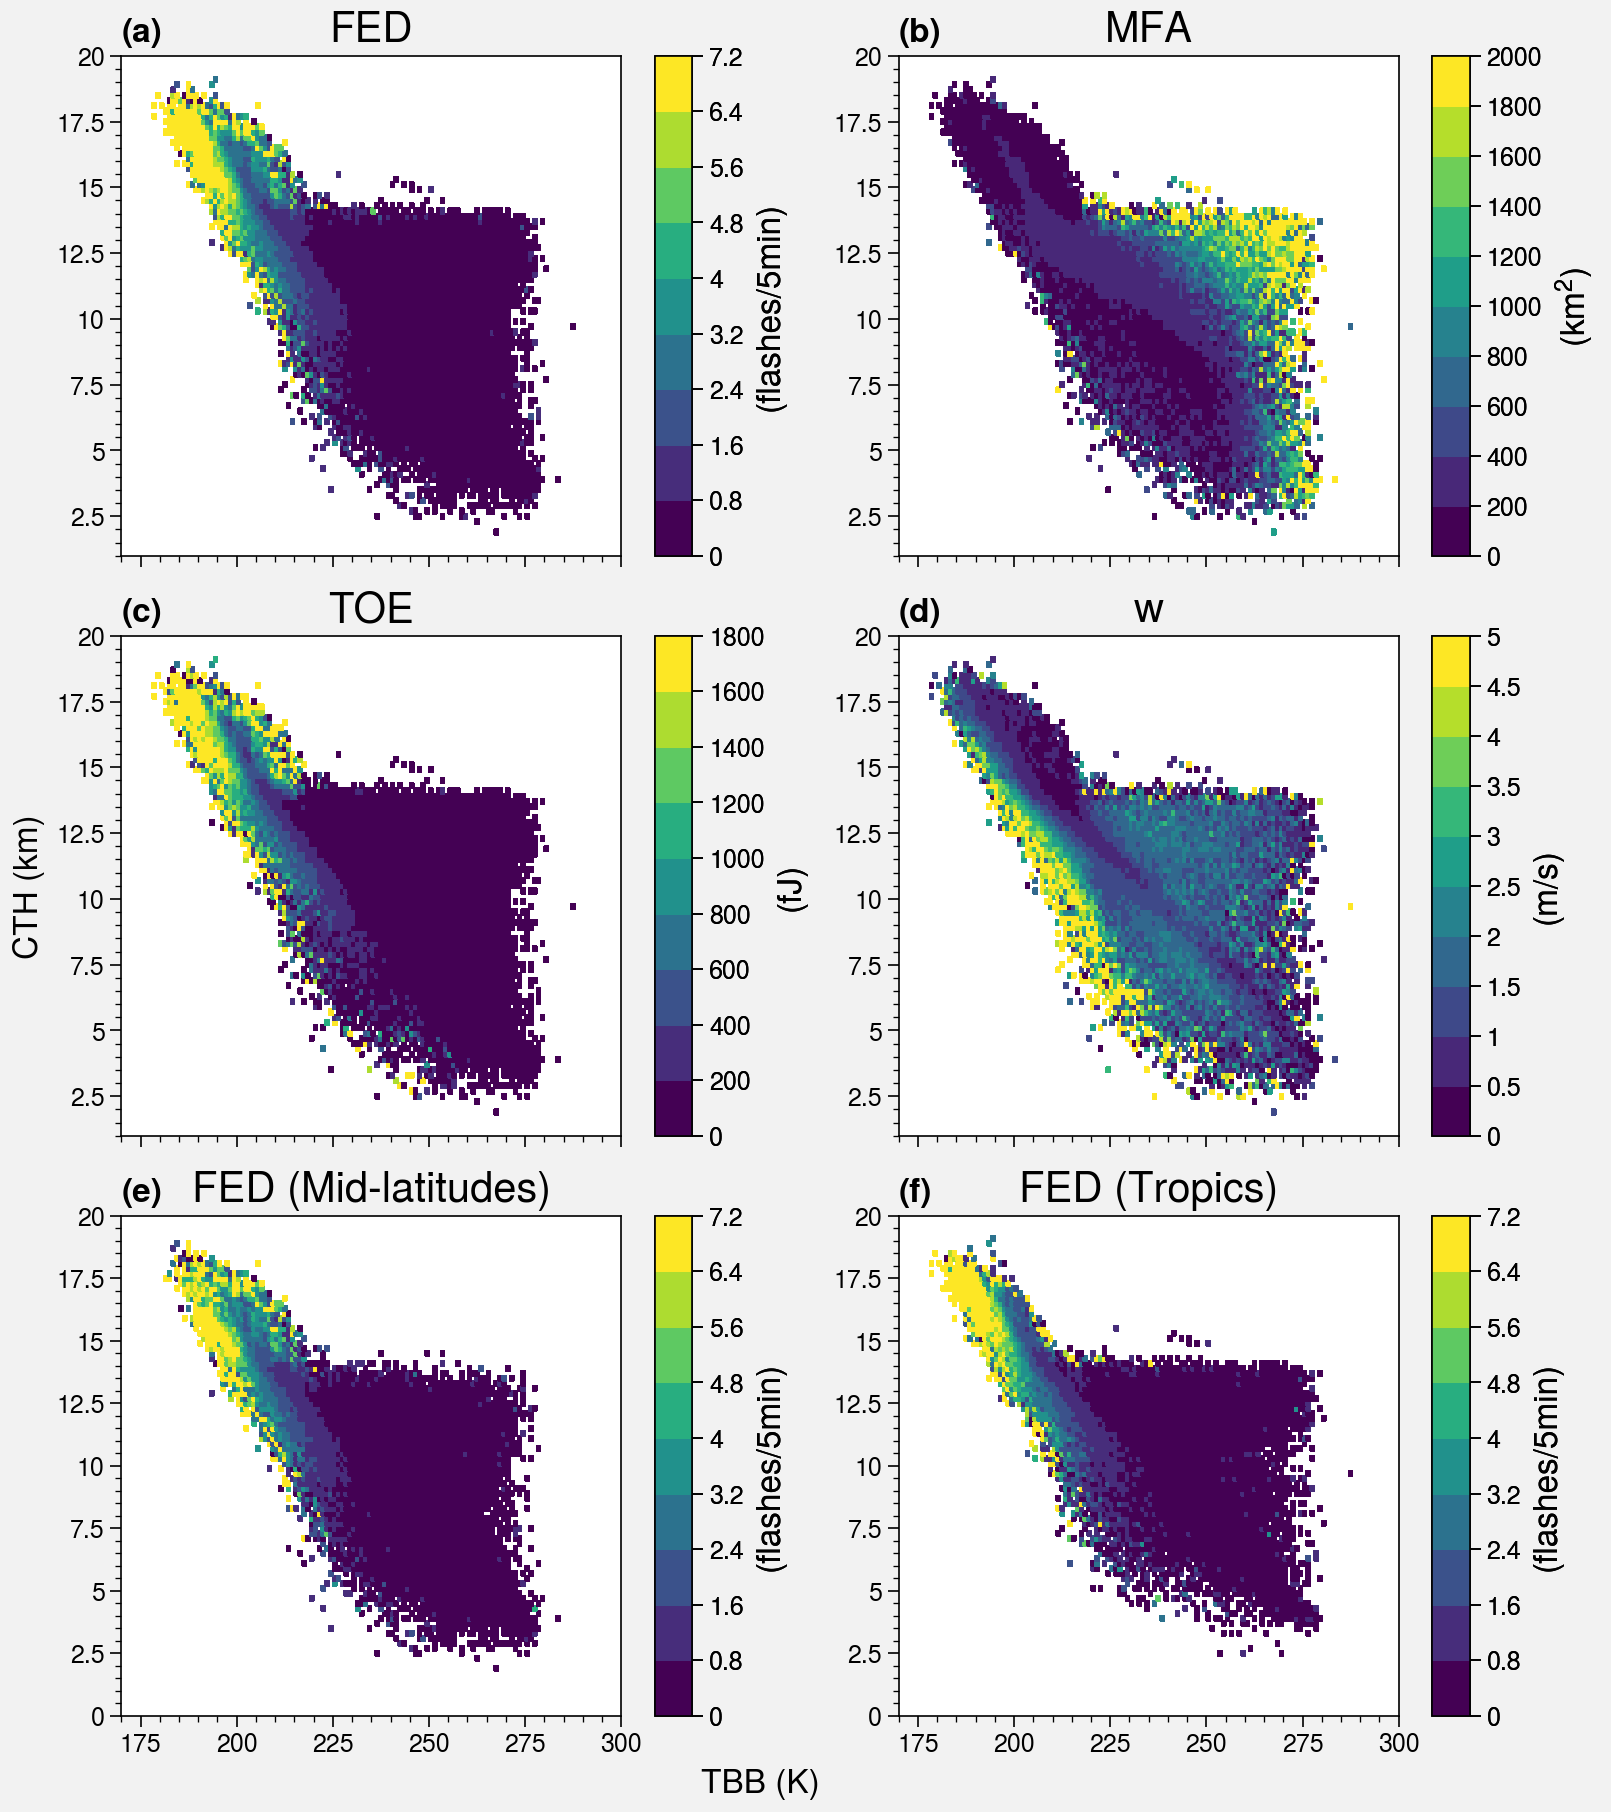

In [7]:
fig, axs = plot.subplots(ncols=2, nrows=3, sharey=1)

gml_vars = {'flash_extent_density': ['FED', 'flashes/5min'],
            'minimum_flash_area': ['MFA', 'km$^2$'],
#             'average_flash_area': ['AFA', 'km$^2$'],
            'total_energy': ['TOE', 'fJ'],
            'w': ['w', 'm/s'],
           }

for idx,var in enumerate(gml_vars.items()):
    stats, cth_edge, tbb_edge = bin_stats(df, relationship='cth-tbb', var_glm=var[0])
    # stats, cth_edge, tbb_edge = bin_stats(df, relationship='cth-tbb', var_glm=var[0])
    x, y = np.meshgrid(tbb_edge, cth_edge)
    m = axs[idx].pcolormesh(x, y, stats,
                            vmax=np.nanpercentile(stats, 95),
                            cmap='viridis')
    axs[idx].colorbar([m], label=f'({var[1][1]})', labelsize=12)
    axs[idx].format(ylim=(1, 20), yminorticks=0.5,
                    xlim=(170, 300), xminorticks=5,
                    xlabel='TBB (K)', ylabel='CTH (km)',
                    title=var[1][0],
                    titlesize=15,
                    )
#     axs[idx].xaxis.label.set_size(12)
#     axs[idx].yaxis.label.set_size(12)

stats, cth_edge, tbb_edge = bin_stats(df[df['lat']>23.5], relationship='cth-tbb', var_glm='flash_extent_density')
x, y = np.meshgrid(tbb_edge, cth_edge)
m = axs[-2].pcolormesh(x, y, stats,
                   vmax=7.2,
                   cmap='viridis')
axs[-2].colorbar([m], labelsize=12, label='(flashes/5min)')
axs[-2].format(title='FED (Mid-latitudes)', titlesize=15)

stats, cth_edge, tbb_edge = bin_stats(df[df['lat']<23.5], relationship='cth-tbb', var_glm='flash_extent_density')
x, y = np.meshgrid(tbb_edge, cth_edge)
m = axs[-1].pcolormesh(x, y, stats,
                   vmax=7.2,
                   cmap='viridis')
axs[-1].colorbar([m], labelsize=12, label='(flashes/5min)')
axs[-1].format(title='FED (Tropics)', titlesize=15)

for ax in axs:
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)

axs.format(abc=True, abcstyle='(a)', abcloc='l', abcsize=12)
fig.savefig('../figures/cth_tbb_glmvars.png')

- FED coincides with MFA and TOE well: large FED ~ small MFA, large TOE
- Large FEDs are mostly located in TBB < 225 K

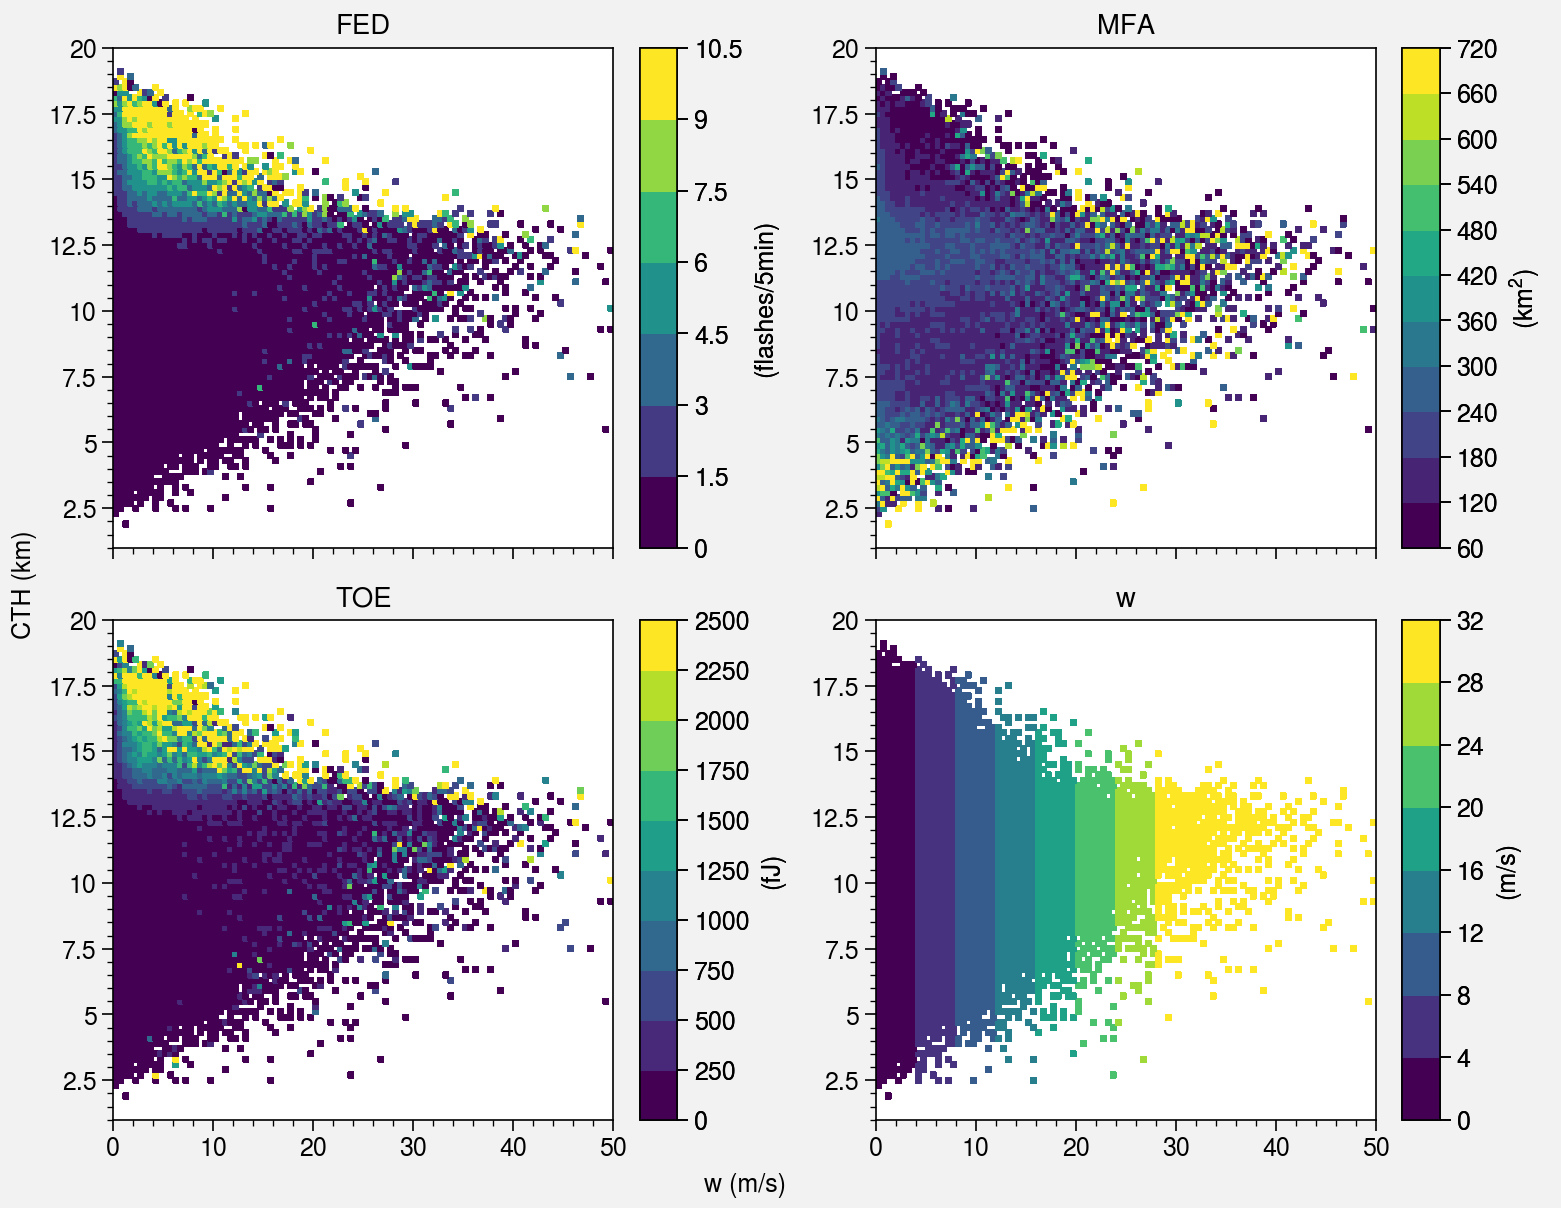

In [8]:
fig, axs = plot.subplots(ncols=2, nrows=2, sharey=1)

for idx,var in enumerate(gml_vars.items()):
    stats, cth_edge, w_edge = bin_stats(df, relationship='w-cth', var_glm=var[0])
    x, y = np.meshgrid(w_edge, cth_edge)
    m = axs[idx].pcolormesh(x, y, stats,
                            vmax=np.nanpercentile(stats, 95),
                            cmap='viridis')
    axs[idx].colorbar([m], label=f'({var[1][1]})')
    axs[idx].format(xlim=(0, 50), xminorticks=2,
                    ylim=(1, 20), yminorticks=0.5,
                    ylabel='CTH (km)', xlabel='w (m/s)',
                    title=var[1][0])

The w decreases with higher CTH when CTH is above 12.5 km.
This coincides well with Jeyavinoth et al. 2020 (10.1029/2020GL090675) which estimates the w using MODIS IR temperature:
the w_max is lower than the CTH and the w at the CTH is small.

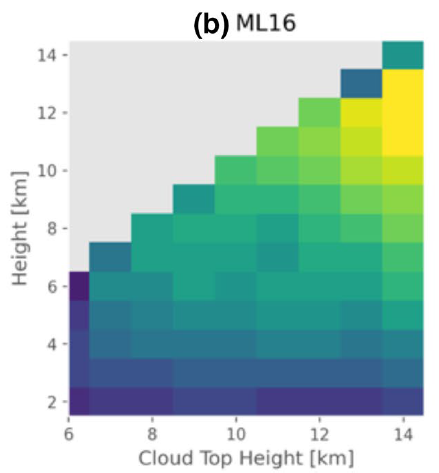

To investigate the lightning parameterization and w ~ CTH, we need to pick CTH <= 12.5 km data

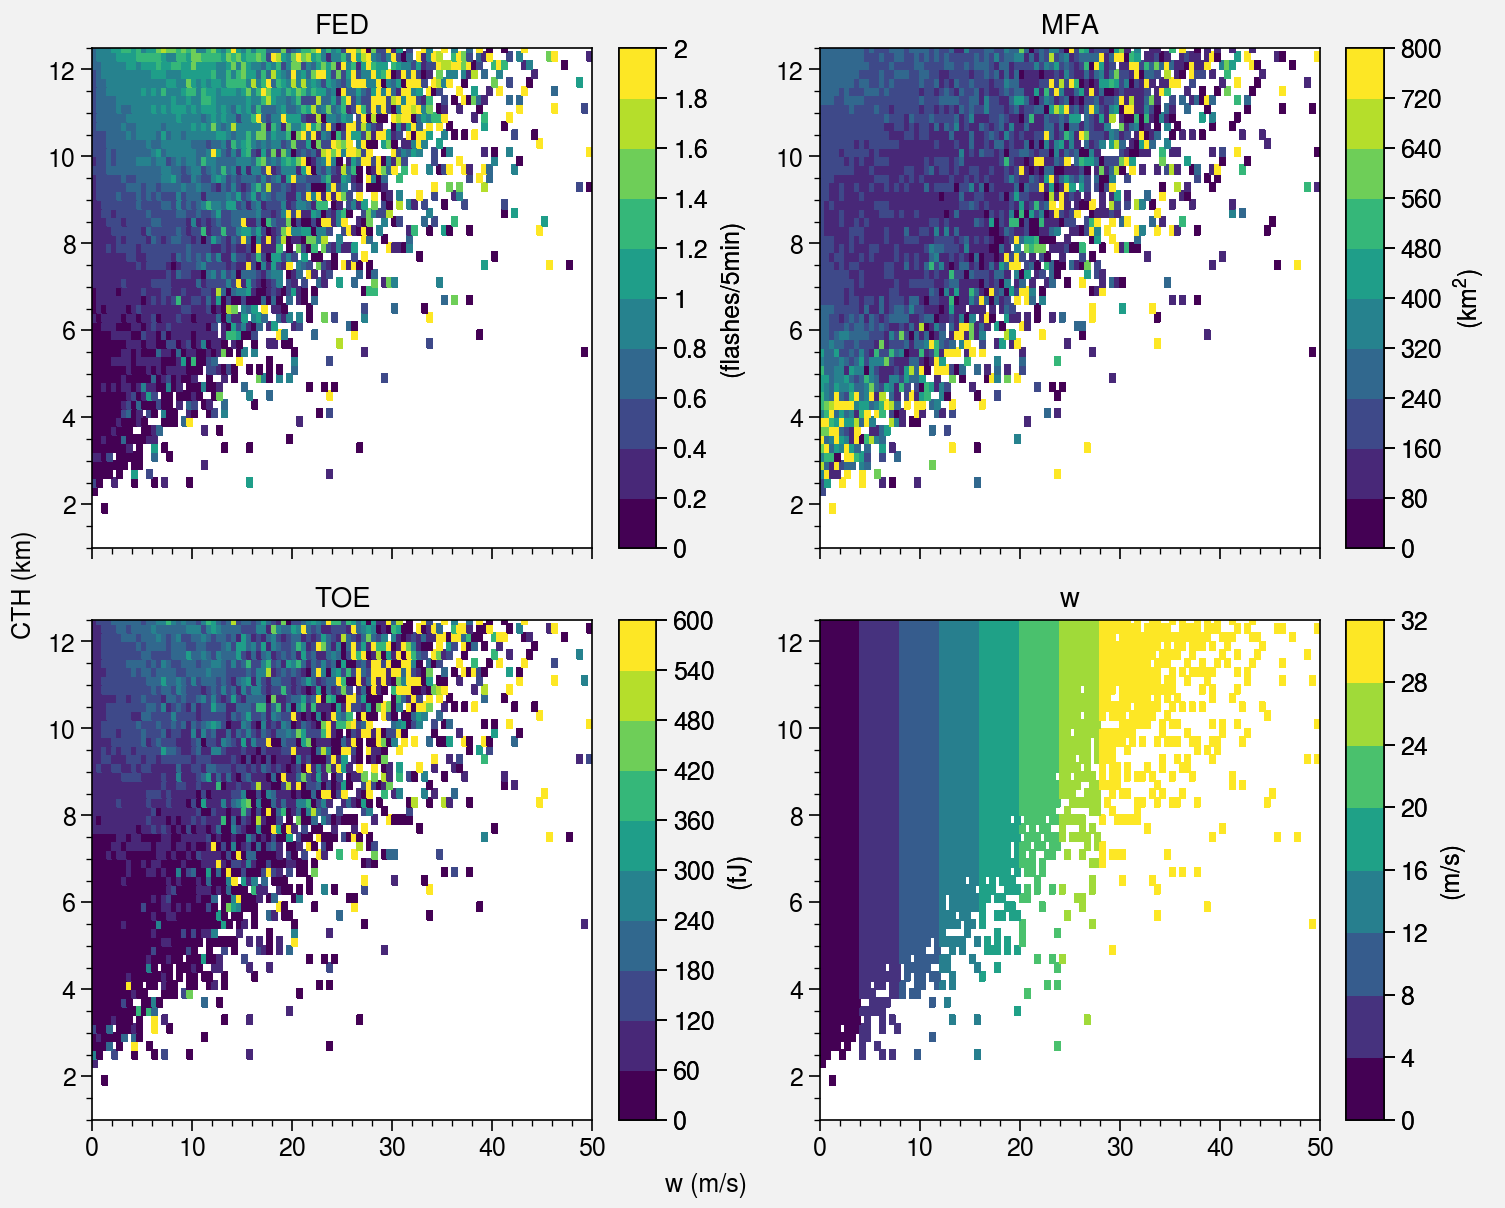

In [9]:
fig, axs = plot.subplots(ncols=2, nrows=2, sharey=1)

for idx,var in enumerate(gml_vars.items()):
    stats, cth_edge, w_edge = bin_stats(df.loc[df['HT']<=12.5], relationship='w-cth', var_glm=var[0])

    x, y = np.meshgrid(w_edge, cth_edge)
    m = axs[idx].pcolormesh(x, y, stats,
                            vmax=np.nanpercentile(stats, 95),
                            cmap='viridis')
    axs[idx].colorbar([m], label=f'({var[1][1]})')
    axs[idx].format(xlim=(0, 50), xminorticks=2,
                    ylim=(1, 12.5), yminorticks=0.5,
                    ylabel='CTH (km)', xlabel='w (m/s)',
                    title=var[1][0])

Em ... Not sounds good. It's better to derive the FED ~ CTH independently of $w$.

### Distribution of Frequency

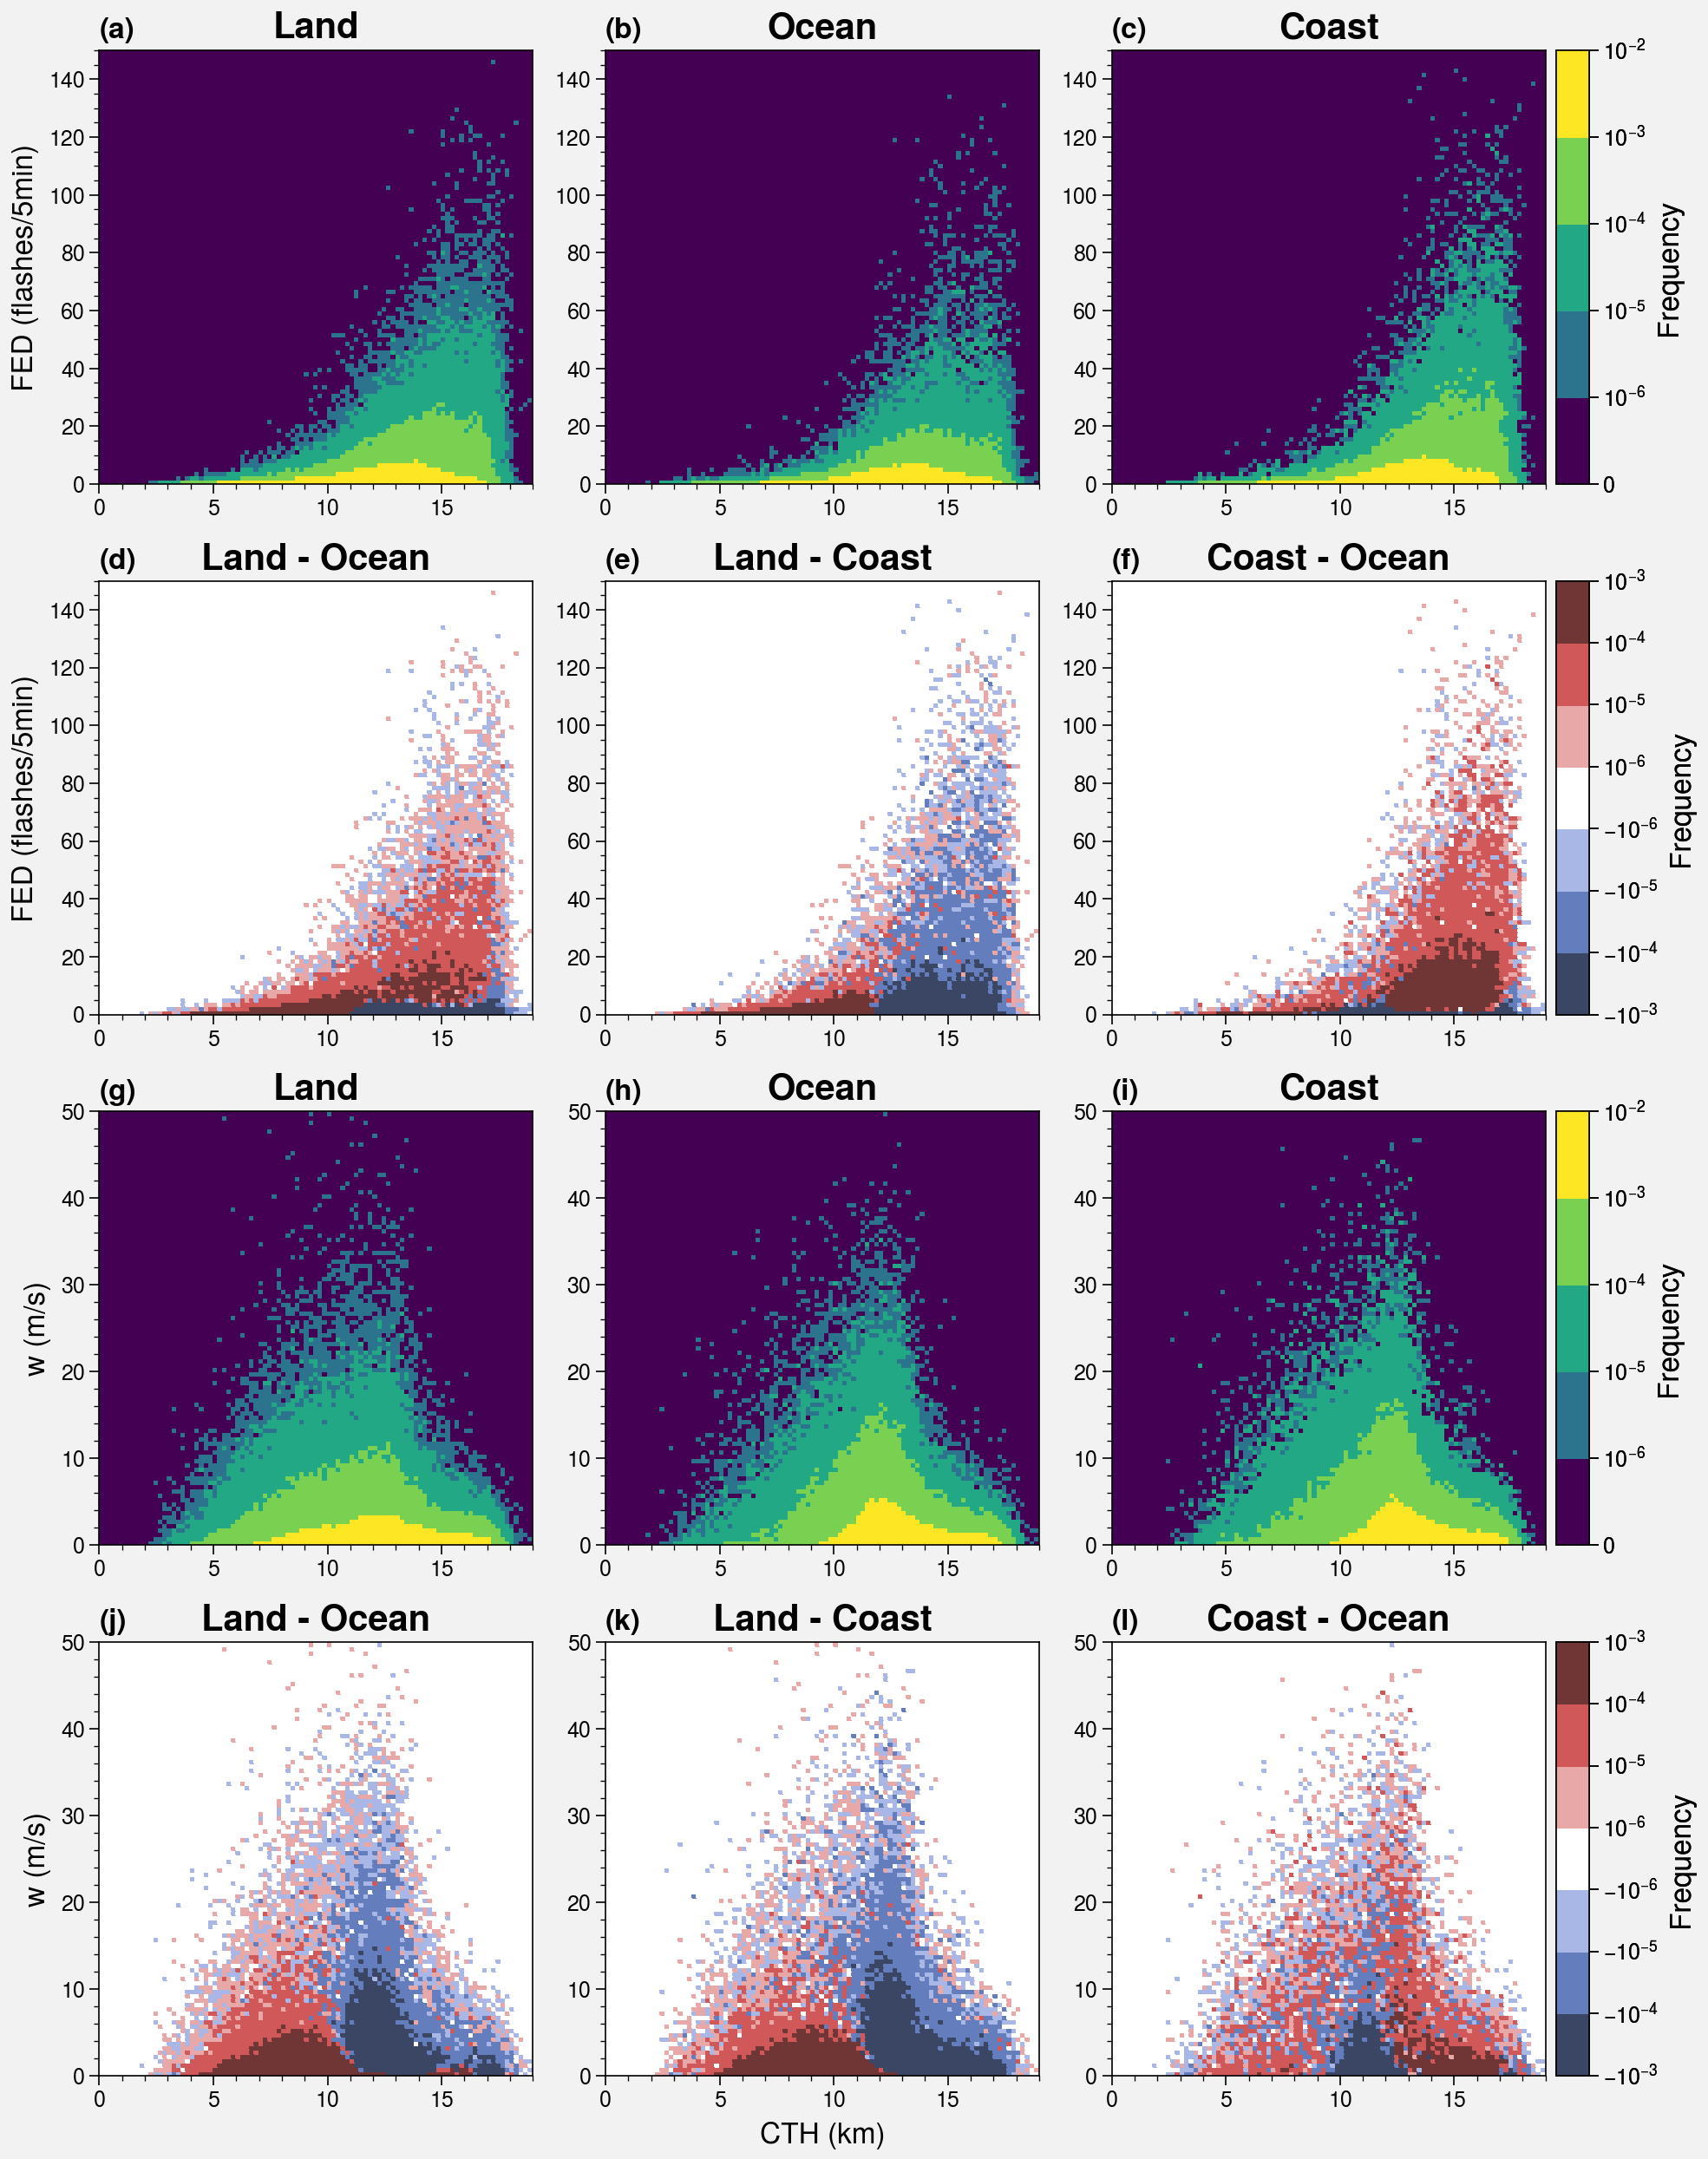

In [10]:
df_land = df[df['area'] == 'land']
df_ocean = df[df['area'] == 'ocean']
df_coast = df[df['area'] == 'coast']

fig, axs = plot.subplots(nrows=4, ncols=3, sharex=1, sharey=0)

# ---------------------- fed ~ cth ----------------------
fed_cth_land, fed_edge, cth_edge = bin_stats(df_land, relationship='fed-cth')
fed_cth_ocean, _, _ = bin_stats(df_ocean, relationship='fed-cth')
fed_cth_coast, _, _ = bin_stats(df_coast, relationship='fed-cth')

x, y = np.meshgrid(cth_edge, fed_edge)

# fill frequency
freq_levels = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
plot_stats(axs[0], x, y, fed_cth_land, 'Frequency', levels=freq_levels, title='Land')
plot_stats(axs[1], x, y, fed_cth_ocean, 'Frequency', levels=freq_levels, title='Ocean')
plot_stats(axs[2], x, y, fed_cth_coast, 'Frequency', levels=freq_levels, title='Coast', plot_clb=True)

# fill difference
diff_levels = [-1e-3, -1e-4, -1e-5, -1e-6, 1e-6, 1e-5, 1e-4, 1e-3]
plot_stats(axs[3], x, y, fed_cth_land-fed_cth_ocean, 'Frequency',
           levels=diff_levels, cmap='Div', title='Land - Ocean')
plot_stats(axs[4], x, y, fed_cth_land-fed_cth_coast, 'Frequency',
           levels=diff_levels, cmap='Div', title='Land - Coast')
plot_stats(axs[5], x, y, fed_cth_coast-fed_cth_ocean, 'Frequency',
           levels=diff_levels, cmap='Div', title='Coast - Ocean',
           plot_clb=True)

axs[:6].format(xlim=(0, 19), xlabel='CTH (km)', ylim=(0, 150), grid=False)
axs[0].format(ylabel='FED (flashes/5min)')
axs[3].format(ylabel='FED (flashes/5min)')

# ---------------------- w ~ cth ----------------------
w_cth_land, w_edge, cth_edge = bin_stats(df_land, relationship='w-cth')
w_cth_ocean, _, _ = bin_stats(df_ocean, relationship='w-cth')
w_cth_coast, _, _ = bin_stats(df_coast, relationship='w-cth')


x, y = np.meshgrid(cth_edge, w_edge)

# fill frequency
plot_stats(axs[6], x, y, w_cth_land, 'Frequency', levels=freq_levels, title='Land')
plot_stats(axs[7], x, y, w_cth_ocean, 'Frequency', levels=freq_levels, title='Ocean')
plot_stats(axs[8], x, y, w_cth_coast, 'Frequency', levels=freq_levels, title='Coast', plot_clb=True)

# fill difference
plot_stats(axs[9], x, y, w_cth_land-w_cth_ocean, 'Frequency',
           levels=diff_levels, cmap='Div', title='Land - Ocean')
plot_stats(axs[10], x, y, w_cth_land-w_cth_coast, 'Frequency',
           levels=diff_levels, cmap='Div', title='Land - Coast')
plot_stats(axs[11], x, y, w_cth_coast-w_cth_ocean, 'Frequency',
           levels=diff_levels, cmap='Div', title='Coast - Ocean',
           plot_clb=True)

axs[6:].format(xlim=(0, 19), xlabel='CTH (km)', ylim=(0, 50), grid=False)
axs[6].format(ylabel='w (m/s)')
axs[9].format(ylabel='w (m/s)')

# set axis labelsize
axs[10].xaxis.label.set_size(12)
axs[0].yaxis.label.set_size(12)
axs[3].yaxis.label.set_size(12)
axs[6].yaxis.label.set_size(12)
axs[9].yaxis.label.set_size(12)

axs.format(abc=True, abcstyle='(a)', abcsize=12)

fig.savefig('../figures/freq_hist.png')

- Sharp decrease of w ~ CTH coincides with sumits of FED ~ CTH
- FED ~ CTH: log relationship;
- w ~ CTH: summit is at CTH ~ 12 km
- Coastal lightning stronger.

In [11]:
# w_center = np.convolve(w_edge, np.ones(2), 'valid') / 2

In [12]:
df_subset = df.loc[(df['HT'] >0) & (df['HT'] <20) & (df['w']>0) & (df['w']<30)]
cth_bins = np.arange(0, 20.2, 0.2)
w_cth_land_mean = binned_statistic(df_subset['HT'],
                 df_subset['w'],
                 statistic='mean',
                 bins=[cth_bins]).statistic

df_subset = df.loc[(df['HT'] >0) & (df['HT'] <20) & 
            (df['flash_extent_density']>0) & (df['flash_extent_density']<80)]
fed_cth_land_mean = binned_statistic(df['HT'],
                       df['flash_extent_density'],
                       statistic='mean',
                       bins=[cth_bins]).statistic

In [13]:
fed_cth_land, fed_edge, cth_edge = bin_stats(df_land, relationship='fed-cth')
fed_cth_ocean, _, _ = bin_stats(df_ocean, relationship='fed-cth')

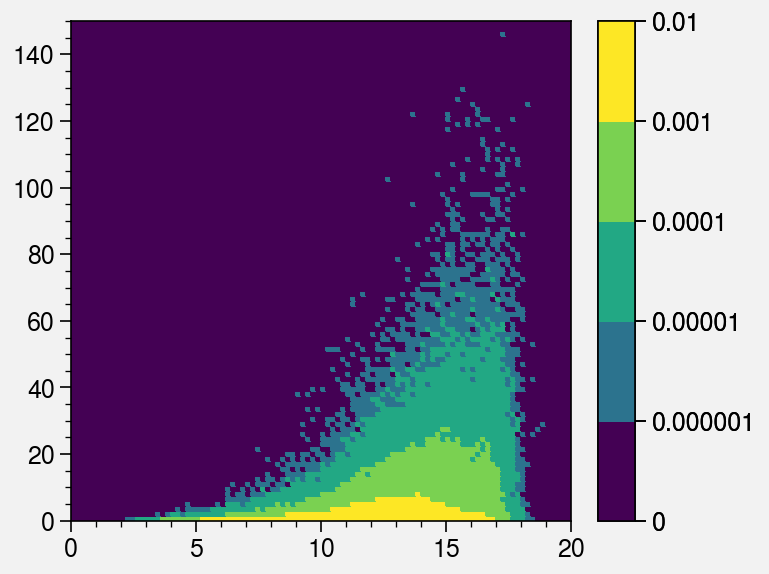

In [14]:
fig, axs = plot.subplots()
ticks = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

m = axs.pcolormesh(cth_edge, fed_edge, fed_cth_land, cmap='viridis', levels=ticks)

# m = axs.pcolormesh(cth_edge, fed_edge, fed_cth_land-fed_cth_ocean,
#                    levels=[-1e-3, -1e-4, -1e-5, -1e-6, 1e-6, 1e-5, 1e-4, 1e-3],
#                    cmap='Div')

axs.colorbar([m], loc='r')

# axs.plot(cth_center, fed_cth_land_mean, c='w')
# axs.plot(cth_center, w_cth_land_mean, c='w')
# axs.plot(cth_center, w_cth_land_p90, c='w')

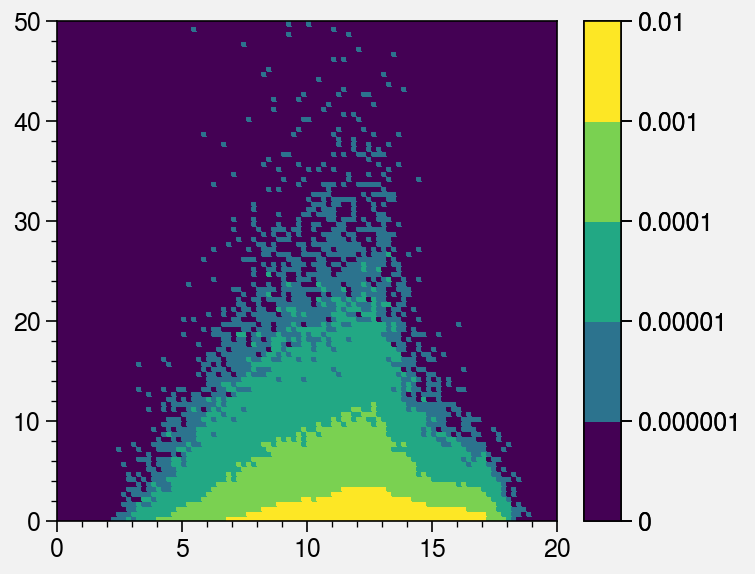

In [15]:
import matplotlib
fig, axs = plot.subplots()
ticks = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

w_cth_land, w_edge, cth_edge = bin_stats(df_land, relationship='w-cth')
m = axs.pcolormesh(cth_edge, w_edge, w_cth_land, vmin=0, cmap='viridis', levels=ticks)
axs.colorbar([m], loc='r')

# axs.plot(cth_center, w_cth_land_mean, c='w')
# axs.plot(cth_center, w_cth_land_mean, c='w')
# axs.plot(cth_center, w_cth_land_p90, c='w')

### Scatter plot (Bak)

In [16]:
# df_land = df[df['area'] == 'land']
# df_ocean = df[df['area'] == 'ocean']
# df_coast = df[df['area'] == 'coast']

# fig, axs = plot.subplots(nrows=2, ncols=3, spanx=0, spany=0)

# # --------------- HT ~ FED ---------------
# axs[0].scatter(df_land['HT'], df_land['flash_extent_density'], s=0.5)
# axs[1].scatter(df_ocean['HT'], df_ocean['flash_extent_density'], s=0.5)
# axs[2].scatter(df_coast['HT'], df_coast['flash_extent_density'], s=0.5)
# axs[:3].format(ylim=(0, 150), ylabel='FED (#/5min)')


# # --------------- HT ~ w ---------------
# axs[3].scatter(df_land['HT'], df_land['w'], s=0.5)
# axs[4].scatter(df_ocean['HT'], df_ocean['w'], s=0.5)
# axs[5].scatter(df_coast['HT'], df_coast['w'], s=0.5)
# axs[3:].format(ylim=(0, 40), ylabel='w (m/s)')

# axs.format(xlim=(1, 19), xlabel='CTH (km)',
#            toplabels=('Land', 'Ocean', 'Coast'),
#            grid=False)

## Regression

The relationship between average FED in each 1km CTH bin and CTH.

In [17]:
def plot_linear(ax, x, y, color, label, plot_line=False):
    data = pd.DataFrame({"flash_extent_density": y, "HT": x})

    model = sm.OLS(np.log10(data.flash_extent_density),
                   sm.add_constant(np.log10(data.HT))).fit()

    intercept = model.params.const
    coef      = model.params.HT
    rsquared  = model.rsquared
    line      = coef*np.log10(data.HT)+intercept

    conf_int = model.conf_int(alpha=0.05, cols=None).loc['HT',:].diff()/2
    conf_int = conf_int[1]

    coef="{:.2f}".format(coef)
    intercept="{:.2f}".format(intercept)
    r="{:.2f}".format(np.sqrt(rsquared))

    # scatter-plot data
    # data.plot.scatter(x='HT',y='flash_extent_density',ax=ax, color=color)

    # plot regression line on the same axes, set x-axis limits
    x_pred  = np.linspace(x.min(), x.max(), 10)
    x_pred2 = sm.add_constant(np.log10(x_pred))
    y_pred  = model.predict(x_pred2)

    if plot_line:
        ax.plot(x_pred, 10**y_pred, '-', color=color)
        if label == 'Land':
            # PR92 land: F = 3.44*10^−5*H^4.9
            ax.plot(x_pred, 3.44e-5*x_pred**4.9, color=color, linestyle='--', label='PR92 Land')
        elif label == 'Ocean':
            # Ashok ocean: F = 2.0*10^−5*H**4.38
            ax.plot(x_pred, 2e-5*x_pred**4.38, color=color, linestyle='--', label='Ashok Ocean')
    title = label+': k='+'10$^{%5.2f}$,'%float(intercept) + ' $\\alpha$='+coef +', R='+r
    
    return title

In [18]:
def plot_regression(ax, df, xname, yname, label, color, statistic='mean',
                    logscale=True, marker='o', calbin=True, plotline=False):
    '''plot the log-log regression'''
    if xname == 'HT':
        xlim = (4, 20)
        xbins = np.arange(5, 20, 1)
    if yname == 'flash_extent_density':
        ylim = (0, 30)
    elif yname == 'w':
        ylim = None
    else:
        ylim = None

    if calbin:
        ret = binned_statistic(df[xname], df[yname],
                               statistic=statistic, bins=xbins)

        x = np.convolve(ret.bin_edges, np.ones(2), 'valid') / 2
        y = ret.statistic
    else:
        x = df[xname]
        y = df[yname]
    s = ax.scatter(x, y, label=label, edgecolor=color,
                   facecolor='None', marker=marker, linewidths=1.5)

    title = plot_linear(ax, x, y, color, label, plotline)

    if logscale:
        ax.format(xlim=xlim, ylim=ylim,
                  xscale='log', yscale='log',
                  xminorlocator=1)
    else:
        ax.format(xlim=xlim, ylim=ylim,
                  xminorlocator=1)

    return s, title

/public/home/zhangxin/new/miniconda3/envs/pyresample_min/lib/python3.8/site-packages/proplot/axes/cartesian.py:621: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)
/public/home/zhangxin/new/miniconda3/envs/pyresample_min/lib/python3.8/site-packages/proplot/axes/cartesian.py:621: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)
/public/home/zhangxin/new/miniconda3/envs/pyresample_min/lib/python3.8/site-packages/proplot/axes/cartesian.py:621: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)


Land: k=10$^{-3.24}$, $\alpha$=3.45, R=0.97


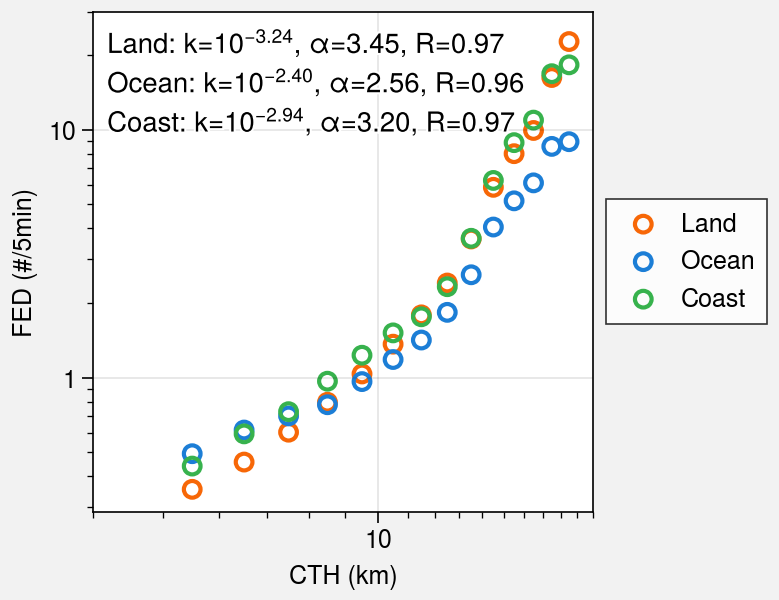

In [19]:
fig, axs = plot.subplots()

s_land, title_land = plot_regression(axs, df_land,
                                         xname='HT', yname='flash_extent_density',
                                         label='Land', color='orange7')

s_ocean, title_ocean = plot_regression(axs, df_ocean,
                                            xname='HT', yname='flash_extent_density',
                                            label='Ocean', color='blue7')

s_coast, title_coast = plot_regression(axs, df_coast,
                                            xname='HT', yname='flash_extent_density',
                                            label='Coast', color='green7')

# def func(x, a, b):
#     return a * np.power(x, b)

def sci_notation(number, sig_fig=2):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    b = int(b)
    return a + '$\\times$10$^{%5.0f}$' % b

# popt_land, _ = curve_fit(func, x_land, y_land)
# popt_ocean, _ = curve_fit(func, x_ocean, y_ocean)
# popt_coast, _ = curve_fit(func, x_coast, y_coast)

# ltitle_land = f'Land: k={sci_notation(popt_land[0])}, a=%5.2f' % popt_land[1]
# ltitle_ocean = f'Ocean: k={sci_notation(popt_ocean[0])}, a=%5.2f' % popt_ocean[1]
# ltitle_coast = f'Coast: k={sci_notation(popt_coast[0])}, a=%5.2f' % popt_coast[1]

print(title_land)
axs.format(ultitle=title_land+'\n'+title_ocean+'\n'+title_coast)
axs.legend([s_land, s_ocean, s_coast], loc='r', ncols=1)
axs.format(xlabel='CTH (km)', ylabel='FED (#/5min)')

/public/home/zhangxin/new/miniconda3/envs/pyresample_min/lib/python3.8/site-packages/proplot/axes/cartesian.py:621: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)
/public/home/zhangxin/new/miniconda3/envs/pyresample_min/lib/python3.8/site-packages/proplot/axes/cartesian.py:621: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)
/public/home/zhangxin/new/miniconda3/envs/pyresample_min/lib/python3.8/site-packages/proplot/axes/cartesian.py:621: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)
/public/home/zhangxin/new/miniconda3/envs/pyresample_min/lib/python3.8/site-packages/proplot/axes/cartesian.py:621: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limi

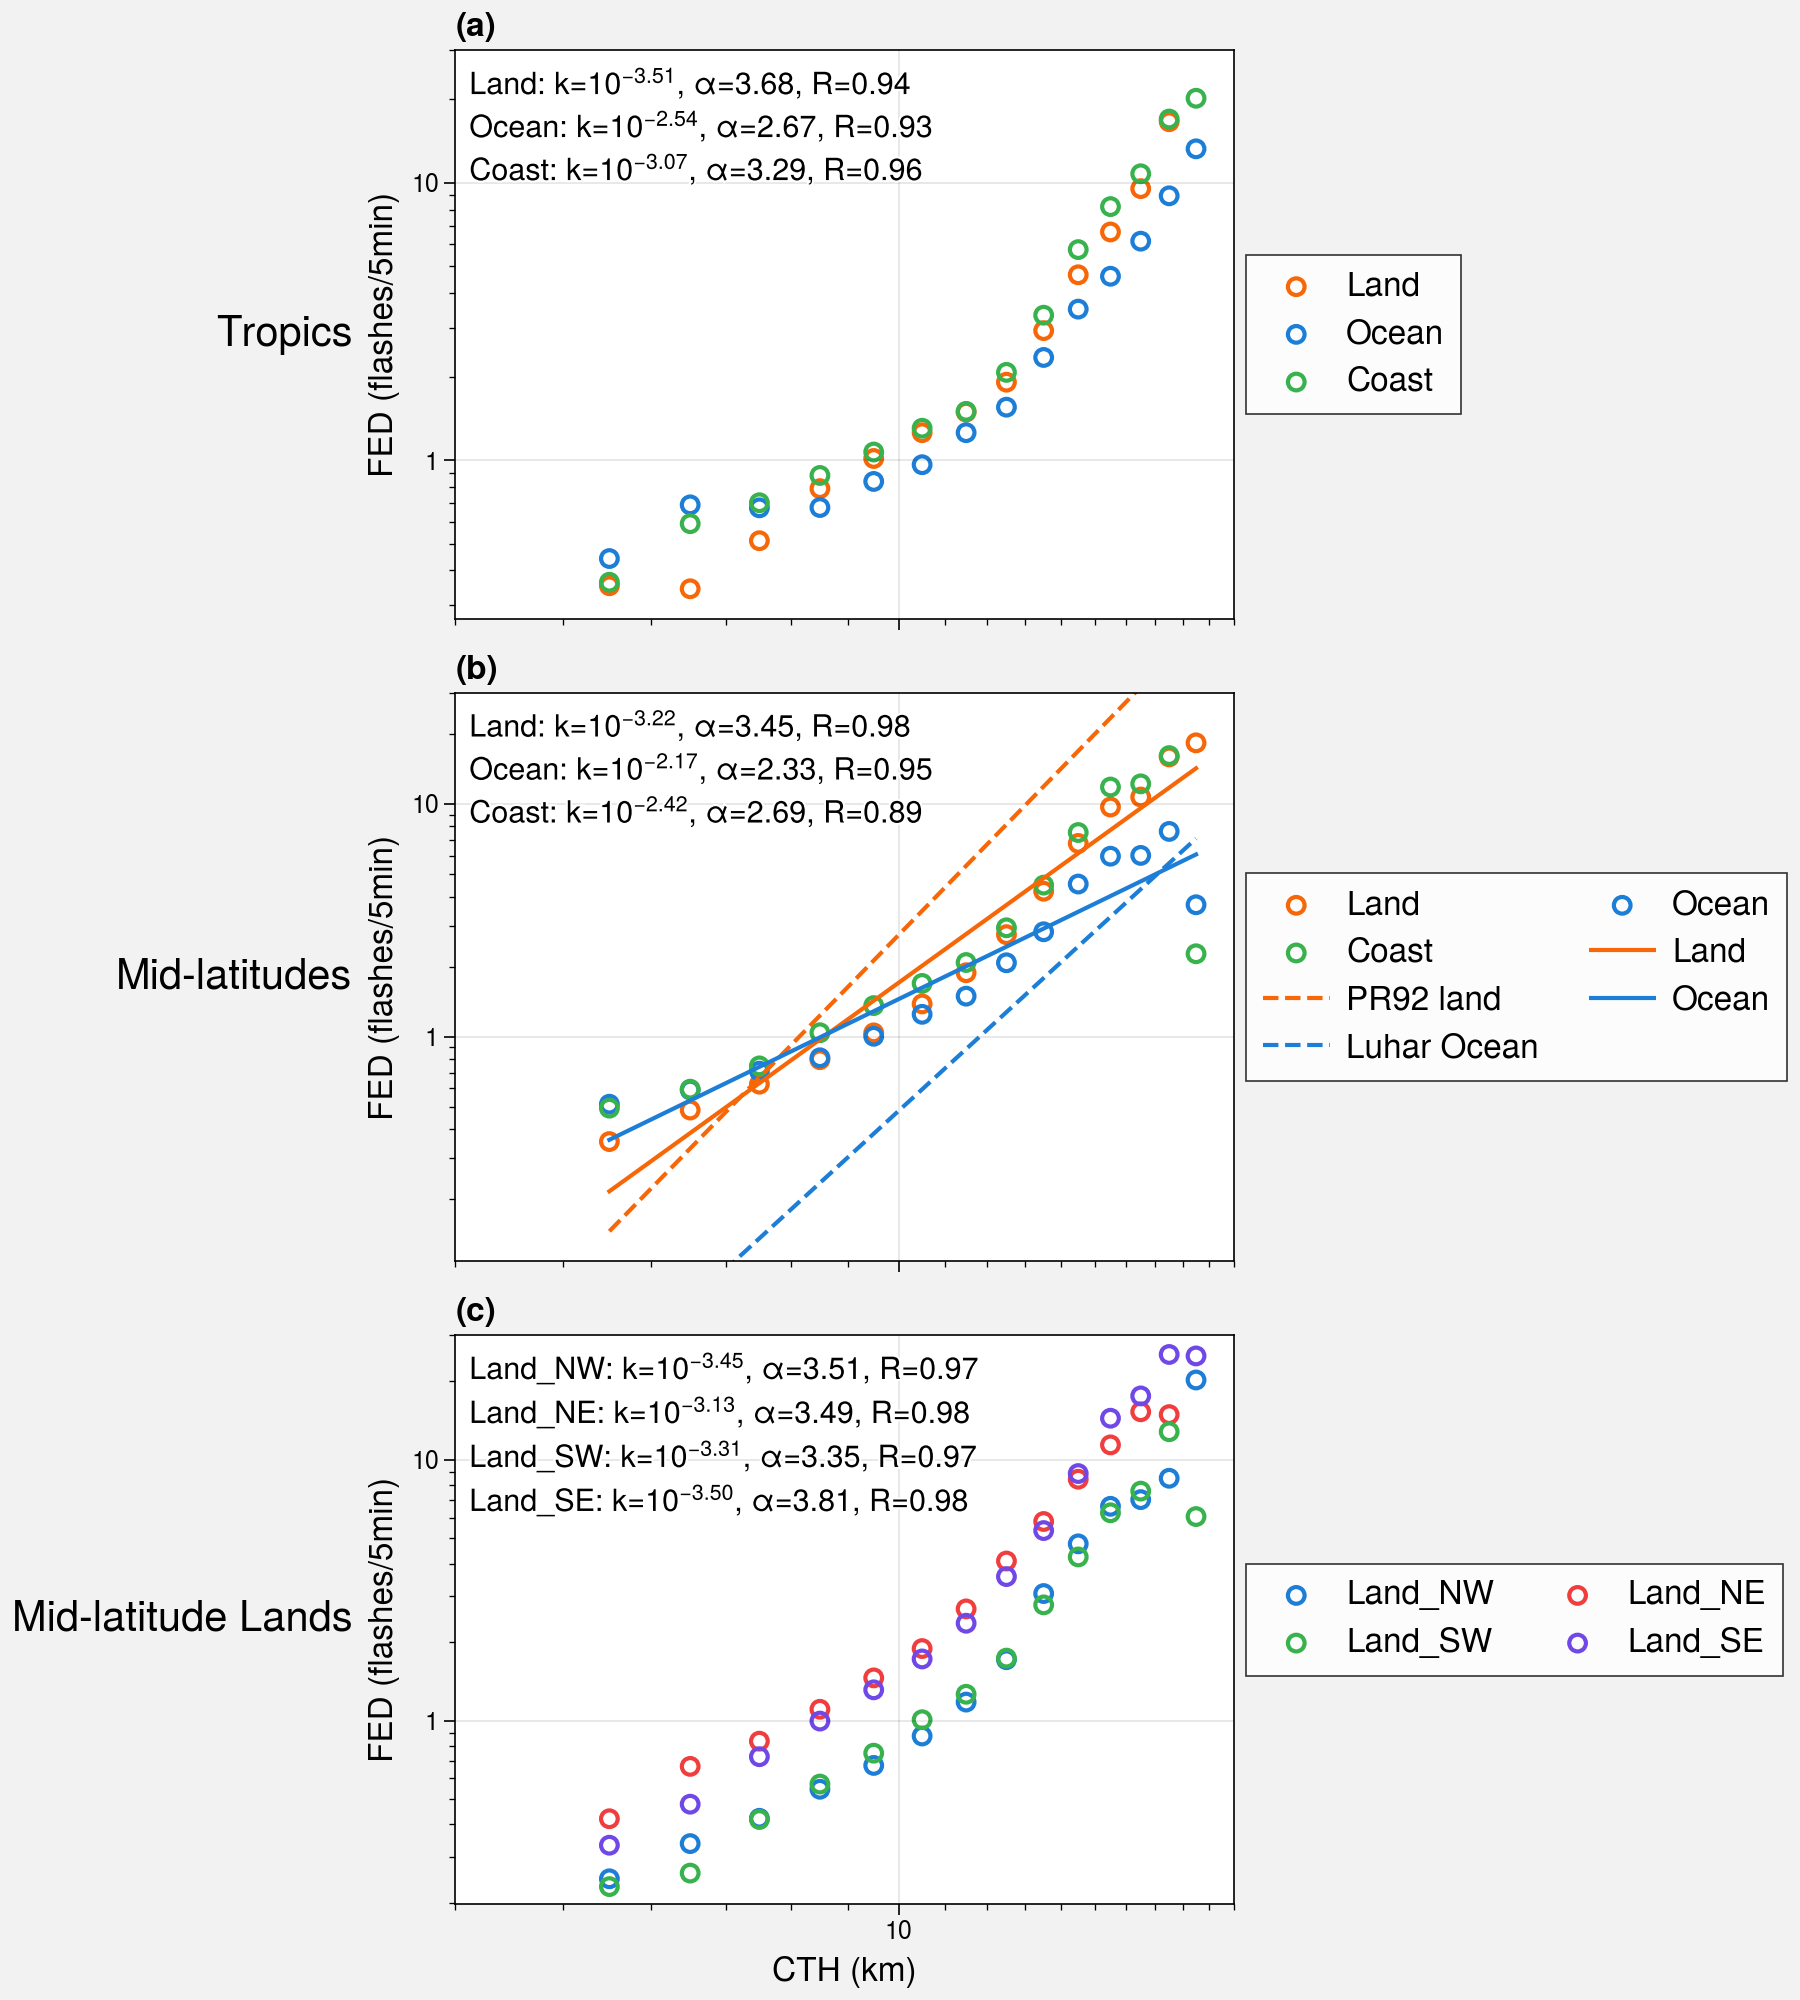

In [20]:
fig, axs = plot.subplots(nrows=3, figsize=(9, 10), sharey=0)

c_land = 'orange7'
c_ocean = 'blue7'
c_coast = 'green7'

s_land, title_land = plot_regression(axs[0], df_land[df_land['lat']<23.5],
                                     xname='HT', yname='flash_extent_density',
                                     label='Land', color=c_land)

s_ocean, title_ocean = plot_regression(axs[0], df_ocean[df_ocean['lat']<23.5],
                                       xname='HT', yname='flash_extent_density',
                                       label='Ocean', color=c_ocean)

s_coast, title_coast = plot_regression(axs[0], df_coast[df_coast['lat']<23.5],
                                       xname='HT', yname='flash_extent_density',
                                       label='Coast', color='green7')

axs[0].legend([s_land, s_ocean, s_coast], ncols=1, loc='r', prop={'size': 12})
axs[0].format(xlabel='CTH (km)')#, ylabel='FED (flashes/5min)')
axs[0].format(ultitle=title_land+'\n'+title_ocean+'\n'+title_coast, titlesize=11)

_, title_land = plot_regression(axs[1], df_land[df_land['lat']>23.5],
                xname='HT', yname='flash_extent_density',
                label='Land', color=c_land, plotline=True)

_, title_ocean = plot_regression(axs[1], df_ocean[df_ocean['lat']>23.5],
                xname='HT', yname='flash_extent_density',
                label='Ocean', color=c_ocean, plotline=True)

_, title_coast = plot_regression(axs[1], df_coast[df_coast['lat']>23.5],
                xname='HT', yname='flash_extent_density',
                label='Coast', color='green7')

# manual line for line legend
from matplotlib.lines import Line2D
l1 = Line2D([0], [0], label='Land', color=c_land)
l2 = Line2D([0], [0], label='PR92 land', linestyle='--', color=c_land)
l3 = Line2D([0], [0], label='Ocean', color=c_ocean)
l4 = Line2D([0], [0], label='Luhar Ocean', linestyle='--', color=c_ocean)

axs[1].legend([s_land, s_ocean, s_coast, l1, l2, l3, l4], ncols=2, loc='r', prop={'size': 12})
axs[1].format(ultitle=title_land+'\n'+title_ocean+'\n'+title_coast, titlesize=11)


s_land_nw, title_land_nw = plot_regression(axs[2], df_land.loc[df_land['region']=='NW'],
                         xname='HT', yname='flash_extent_density',
                         label='Land_NW', color='blue7')

s_land_ne, title_land_ne = plot_regression(axs[2], df_land.loc[df_land['region']=='NE'],
                         xname='HT', yname='flash_extent_density',
                         label='Land_NE', color='red7')

s_land_sw, title_land_sw = plot_regression(axs[2], df_land.loc[df_land['region']=='SW'],
                         xname='HT', yname='flash_extent_density',
                         label='Land_SW', color='green7')

s_land_se, title_land_se = plot_regression(axs[2], df_land.loc[df_land['region']=='SE'],
                         xname='HT', yname='flash_extent_density',
                         label='Land_SE', color='violet7')

axs[2].legend([s_land_nw, s_land_ne, s_land_sw, s_land_se], ncols=2, loc='r', prop={'size': 12})
axs[2].format(ultitle=title_land_nw+'\n'+title_land_ne+'\n'+title_land_sw+'\n'+title_land_se, titlesize=11)


axs.format(leftlabels=['Tropics', 'Mid-latitudes', 'Mid-latitude Lands'],
           leftlabelsize=15,
           leftlabelweight='normal',
           ylim=(0, None),
           abc=True, abcstyle='(a)', abcsize=12, abcloc='l',
           ylabel='FED (flashes/5min)',
          )

for ax in axs:
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)

fig.savefig('../figures/cth_proxy.png')

We don't see the large difference of relationship between ocean and land.

Note that Luhar et al. (2021) and Ushio et al (2001) only did the regression for CTH > 13 km data:

Luhar et al. (2021): Fig. 1

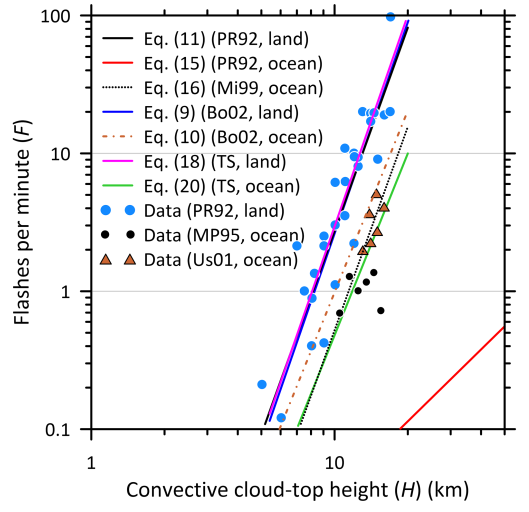

Ushio et al (2001): Fig. 3

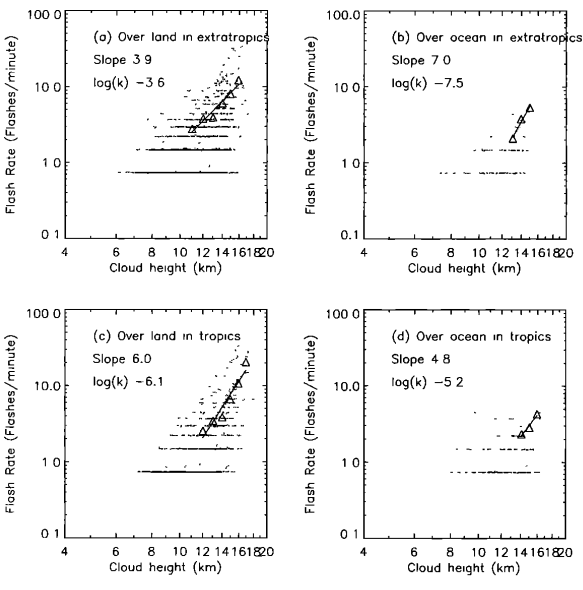

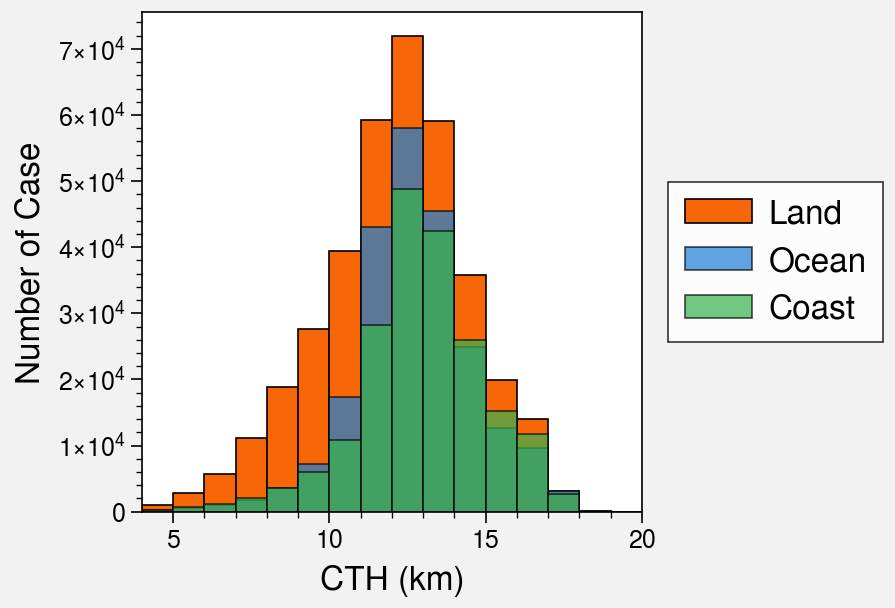

In [21]:
# plot the counts in each bin
fig, axs = plot.subplots()

cth_bins = np.arange(0, 21, 1)

h1 = axs.hist(df_land['HT'], bins=(cth_bins), color=c_land, label='Land')
h2 = axs.hist(df_ocean['HT'], bins=(cth_bins), color=c_ocean, label='Ocean', alpha=0.7)
h3 = axs.hist(df_coast['HT'], bins=(cth_bins), color=c_coast, label='Coast', alpha=0.7)

axs.legend(ncols=1, loc='r', prop={'size': 12})

axs.format(yformatter='sci',
           xlim=(4, 20),
           xlabel='CTH (km)',
           ylabel='Number of Case',
           grid=False
          )

for ax in axs:
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)

fig.savefig('../figures/cth_hist.png')

Well ... We actually have enough good data for low clouds. It needs more future works of low cloud with high FED.

## Discussions

Note that the CTH detected by the TRMM PR is the 20 dBZ echo top which is lower than the IR CTH (see Fig. 12 of https://doi.org/10.1175/JCLI4023.1).

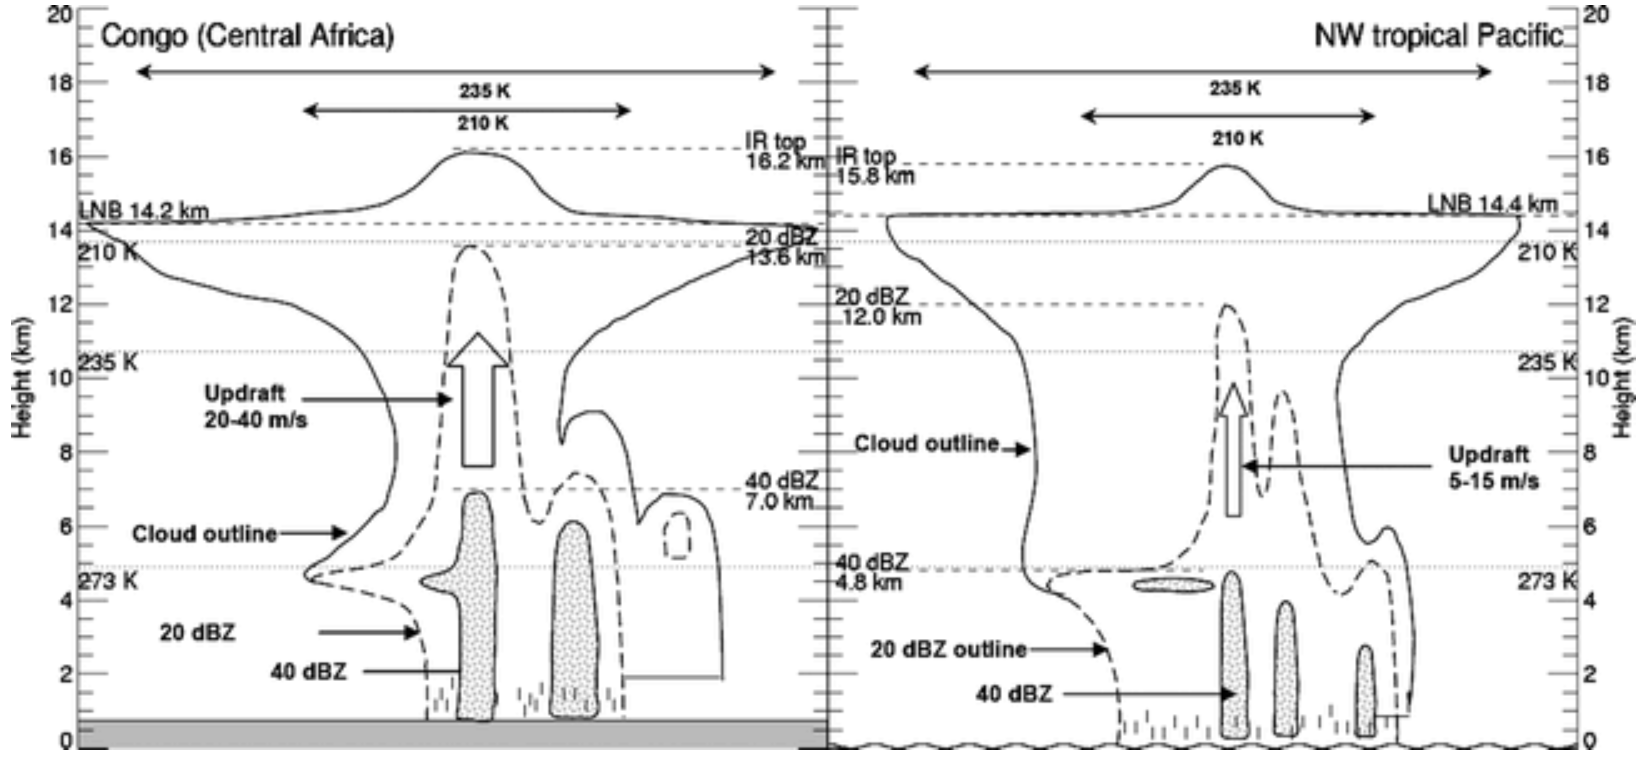

The difference should be larger if the cloud is higher. This can explain the raised tail.

- If we do the regression for data at all height levels, that formular can be used for GEOS satellite or model to predict the lightning.
- If more work can be done for fix the difference between IR CTH and 20 dBZ CTH, then it can also be applied to model which uses the 20 dBZ to preidct lightning.

As mentioned in Adler et al. (1979), the w_max is at different height levels for different convections.

Usually, the w_max exists between 6 km and 9 km. Above 9 km, the w will decrease. Our results coincide with theirs well.

However, the updraft should be larger for deep convections, this means the regression between w and CTH using GOES data isn't suitable.

It's better to use the Cloudsat CPR data like eyavinoth Jeyaratnam et al. (2021) and Masunaga, H., & Luo, Z. J. (2016).

---

Furthermore, the ocean and coast data show the stronger updraft compared with land data. According to Price et al. (1992), this phenomenon exists below 3km:

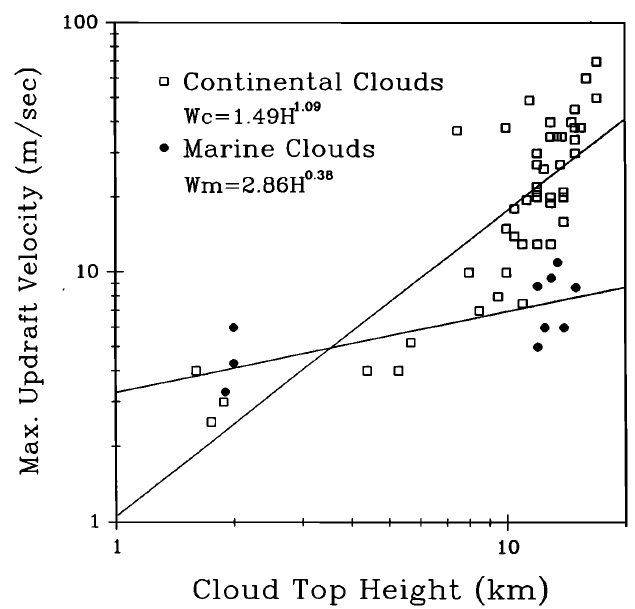

Two possible parameters can lead to this difference:

- Few ocean data in Price 92
- we use w_top and they used w_max